# Deeplabv3 Evaluation
Pipeline voor het evalueren van een model (gegeven de modelclass en de weights)

In [44]:
import copy
import csv
import os
import time
from typing import Any, Callable, Optional
from pathlib import Path

import numpy as np
from PIL import Image
from tqdm import tqdm

import tensorflow as tf

import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

from dataset import SegmentationDataset

DATA_DIR = "data/Amazon Rainforest corrected"

In [2]:
import dataset
from model import createDeepLabv3, train_model

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Het model is al getraind buiten de notebook, de weights en biases hiervoor kunnen opgehaald worden door simpelweg de weights in te laden in het model

In [4]:
model = createDeepLabv3()
model.load_state_dict(torch.load("test/model_state.pth"))
model.eval()  # Model wordt niet meer getraind.
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [5]:
# Get the image and mask pairs, convert them to numpy arrays for application as test.
# imagearray = []
# maskarray = []

# imagedir = Path(DATA_DIR) / "PNG"
# maskdir = Path(DATA_DIR) / "Masks"

# images = sorted(imagedir.glob("*"))
# masks = sorted(maskdir.glob("*"))

# if len(images) != len(masks):
#     raise IndexError
    
# for i in range(len(images)):
#     imgpath = images[i]
#     mskpath = masks[i]
#     with open(imgpath,'rb') as img, open(mskpath,'rb') as msk:
#         image = Image.open(img).convert("RGB")
#         mask = Image.open(msk).convert("L")
#         imagearray.append(np.array(image))
#         maskarray.append(np.array(mask))
        
# maskarray_norm = [x.normalize() for x in maskarray]

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
data = SegmentationDataset("data/Amazon Rainforest corrected","PNG","Masks",transform)

In [8]:
# https://stackoverflow.com/questions/53570732/get-single-random-example-from-pytorch-dataloader
randomindx = np.random.randint(data.__len__())
subset_indices = [randomindx]
subset = Subset(data, subset_indices)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

In [12]:
for i in testloader_subset:
    x = i
x

{'image': tensor([[[[0.4745, 0.4353, 0.4000,  ..., 0.1098, 0.1020, 0.0980],
           [0.4431, 0.4000, 0.3412,  ..., 0.1059, 0.1020, 0.1020],
           [0.3765, 0.3176, 0.3098,  ..., 0.1176, 0.1098, 0.1020],
           ...,
           [0.0980, 0.0980, 0.1020,  ..., 0.1098, 0.1098, 0.1059],
           [0.1020, 0.1059, 0.1059,  ..., 0.1216, 0.1098, 0.1059],
           [0.1059, 0.1098, 0.1059,  ..., 0.1059, 0.1098, 0.1059]],
 
          [[0.3843, 0.3569, 0.3451,  ..., 0.1804, 0.1804, 0.1725],
           [0.3725, 0.3373, 0.3098,  ..., 0.1843, 0.1843, 0.1804],
           [0.3294, 0.2902, 0.2902,  ..., 0.1961, 0.1882, 0.1843],
           ...,
           [0.1843, 0.1843, 0.1804,  ..., 0.1843, 0.1922, 0.1882],
           [0.1922, 0.2000, 0.1882,  ..., 0.1843, 0.1922, 0.1882],
           [0.1843, 0.2000, 0.1882,  ..., 0.1804, 0.1804, 0.1804]],
 
          [[0.3529, 0.3373, 0.3176,  ..., 0.2039, 0.2000, 0.2039],
           [0.3490, 0.3255, 0.3059,  ..., 0.2039, 0.2000, 0.2039],
           [0.3

In [83]:
inp = x['image'].to(device)
pred = model(inp)
pred

OrderedDict([('out',
              tensor([[[[0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
                        [0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
                        [0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
                        ...,
                        [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334],
                        [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334],
                        [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334]]]],
                     grad_fn=<UpsampleBilinear2DBackward1>)),
             ('aux',
              tensor([[[[ 5.5605,  5.5605,  5.5605,  ...,  9.1172,  9.1172,  9.1172],
                        [ 5.5605,  5.5605,  5.5605,  ...,  9.1172,  9.1172,  9.1172],
                        [ 5.5605,  5.5605,  5.5605,  ...,  9.1172,  9.1172,  9.1172],
                        ...,
                        [ 6.5437,  6.5437,  6.5437,  ...,  6.4543,  6.4543,  6.4543],
           

In [66]:
pred['out'].shape

torch.Size([1, 1, 512, 512])

In [68]:
pred['out'][0]

tensor([[[0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
         [0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
         [0.1847, 0.1847, 0.1847,  ..., 0.5159, 0.5159, 0.5159],
         ...,
         [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334],
         [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334],
         [0.5939, 0.5939, 0.5939,  ..., 0.6334, 0.6334, 0.6334]]],
       grad_fn=<SelectBackward>)

In [84]:
m = Softmax(dim=1)  # Proberen om labels om te zetten naar 0 of 1, werkt volgensmij niet helemaal naar behoren.
inpsm = pred['out'].to(device)
predsm = m(inpsm)
presdm

In [77]:
predarray = predsm.data.cpu().numpy()  # Labelt alles als 1...?
predarray

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]], dtype=float32)

In [78]:
# predarray.shape

In [79]:
# predarray[0].shape

In [80]:
# predarray[0]

In [81]:
# predarray[0]

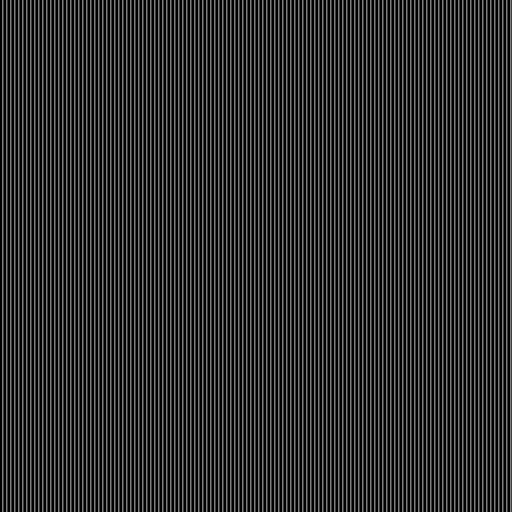

In [82]:
predimg = Image.fromarray(predarray[0][0],"L")
predimg  # Image klopt volgensmij ook van geen kant.